# Netherlands Neurogenetics Database
Author: Nienke Mekkes <br>
Date: 21-Sep-2022. <br>
Correspond: n.j.mekkes@umcg.nl <br>

## Script: clinical history labeled training data: cleaning & exploration
Objectives: load and clean training data, do some basic data exploration


### Input files:
- excel file with labeled training data

### Output:
- excel file with cleaned labeled training data 
- pickle file with cleaned labeled training data
- folder with figures with basic data explorations


#### Imports

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pywaffle import Waffle
from datetime import date


#### Paths (user input required)

In [2]:
path_to_training_data = ""
save_path_files = ""
save_path_figures = "" ## optional

In [6]:
if not os.path.exists(save_path_figures):
    print('Creating figure folder....\n')
    os.makedirs(save_path_figures)
    
if not os.path.exists(save_path_files):
    print('Creating output folder....')
    os.makedirs(save_path_files)

Creating figure folder....

Creating output folder....


### Loading data

Training data comes in the form of an excel file with a tab per donor. <br>
Merge all Excel sheets together with concat, keeping the sheet names. <br>
The sheet names are the patient identifiers. <br>
Note, empty sheets (== donors without clinical history) are ignored by concat <br>

In [1]:
## Takes some time, so run only once. Rest of script functions on data copy.
pd_df = pd.read_excel(path_to_training_data, engine='openpyxl', index_col=[0], sheet_name=None)
concat_training_data = pd.concat(pd_df, axis=0, ignore_index=True)


NameError: name 'pd' is not defined

In [7]:
print('Before combining donors, training data has ', len(pd_df.keys()), 'unique NBB identifiers.')
print('After combining donors, training data has ',len(training_data['NBB_nr'].unique()),'unique NBB identifiers.')
before_concat = list(pd_df.keys())
after_concat = list(training_data['NBB_nr'].unique())

print('Donor files without clinical history are:',list(np.setdiff1d(before_concat,after_concat)))


Before combining donors, training data has  297 unique NBB identifiers.
After combining donors, training data has  293 unique NBB identifiers.
Donor files without clinical history are: ['NBB 2002-069', 'NBB 2003-009', 'NBB 2016-095', 'NBB 2018-121']


### Cleaning part 1
-Remove NaN sentences <br>
-Remove sentences that are just a year <br>
-Make sure that all values are a boolean of either 1 or 0. <br>

In [8]:
print('Before first round of cleaning, we have ',training_data.shape[0],'sentences.')

## remove NaN
training_data = training_data[training_data['Sentence'].notna()]

## removing (year) sentences
year = '\(\d+\)$'
training_data = training_data[lambda x: ~x['Sentence'].str.match(year)]

## Shows the unique values in the 90 columns 
print('All values present in training data: ',
      pd.unique(training_data.loc[:,[i for i in list(training_data.columns) if i not in non_attribute_columns]].values.ravel('K')))

training_data = training_data.replace("TRUE ", True)
training_data = training_data.replace("TRUE", True)
training_data = training_data.replace("True", True)
training_data = training_data.replace('False', False)
training_data = training_data.replace(True, 1)
training_data = training_data.replace(False, 0)
print('All values present in training data after conversion: ',
      pd.unique(training_data.iloc[:, 3:93].values.ravel('K')))

print('After first round of cleaning, we have ',training_data.shape[0],'sentences.')

Before first round of cleaning, we have  19055 sentences.
All values present in training data:  [False True 'False' 'TRUE ']
All values present in training data after conversion:  [0 1]
After first round of cleaning, we have  18987 sentences.


### Cleaning part 2
-Add non_attribute columns with Sentence length, number of scored attributes <br>
-Remove sentences with more than 8 attributes <br>
-Remove sentences with fewer than 6 characters <br>

In [ ]:
training_data = training_data[training_data.loc[:,[i for i in list(training_data.columns) if i not in non_attribute_columns]].sum(axis=1) < 9]
training_data = training_data[training_data.Sentence.str.len() >= 6]
training_data.loc[:,[i for i in list(training_data.columns) if i not in non_attribute_columns]].astype(int)
# training_data =training_data[training_data['sentence_length'] <= 200]
print('After second round of cleaning, we have ',training_data.shape[0],'sentences.')

#### Save as cleaned training data

In [12]:
# since we cleaned up the training sentence file nicely, lets save it inbetween. this will be used to split the data.
training_data.to_excel(f"{save_path_files}/cleaned_training_data.xlsx")
training_data.to_pickle(f"{save_path_files}/cleaned_training_data.pkl") 

### DATA EXPLORATION (optional)
#### How long are our training sentences?

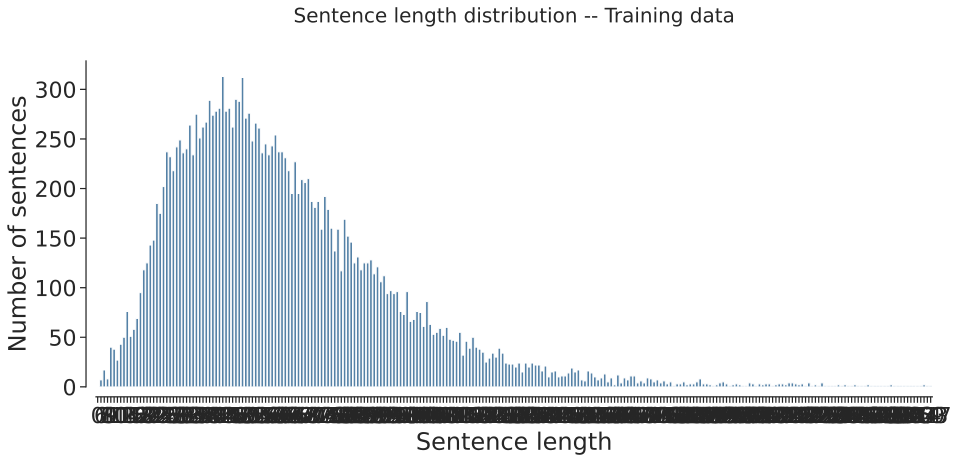

In [13]:
training_data["sum_true"] = training_data.loc[:,[i for i in list(training_data.columns) if i not in non_attribute_columns]].sum(axis=1)
training_data['sentence_length'] = training_data.Sentence.str.len()

%config InlineBackend.figure_format = 'svg'
sns.set(rc={'figure.figsize':(15,6)},font_scale = 2) #
sns.set_palette("pastel")
sns.set_style("ticks")

## get the frequency of the previously created column sentence_length
length_distribution = pd.DataFrame(training_data['sentence_length'].value_counts())
length_distribution['x'] = length_distribution.index
length_distribution.columns = ['nr_sentences','sentence_length']
zero_row = {'nr_sentences':0, 'sentence_length':0}
# length_distribution = length_distribution.append(zero_row, ignore_index=True)
length_distribution = pd.concat([length_distribution, pd.DataFrame.from_records([zero_row])],
                                ignore_index=True)
length_distribution = length_distribution.sort_values(by=['sentence_length'])

## plot and save
lh = sns.barplot(x="sentence_length", y="nr_sentences", data=length_distribution,color='steelblue')
lh.set(xlabel="Sentence length", ylabel="Number of sentences")
plt.title("Sentence length distribution -- Training data", y=1.1, fontsize = 20)
plt.xticks(rotation=90)
for ind, label in enumerate(lh.get_xticklabels()):
    if ind == 0:
        label.set_visible(True)
    elif ind % 10 == 0: 
        label.set_visible(True)
    else:
        label.set_visible(False)

sns.despine(offset=10, trim=False)
lh.spines["right"].set_color("none")
lh.spines["top"].set_color("none")

plt.savefig(save_path_figures + "/training_data_sentence_length_distribution_{}.png".format(date.today()),
            dpi=600, bbox_inches="tight")
plt.savefig(save_path_figures + "/training_data_sentence_length_distribution_{}.pdf".format(date.today()),
            dpi=600, bbox_inches="tight")
plt.show()
plt.close()

### How many sentences have how many attributes?
We expect that most sentences have no attribute, many sentences will have a single attribute, and a high amount of attributes for a single sentence is unlikely

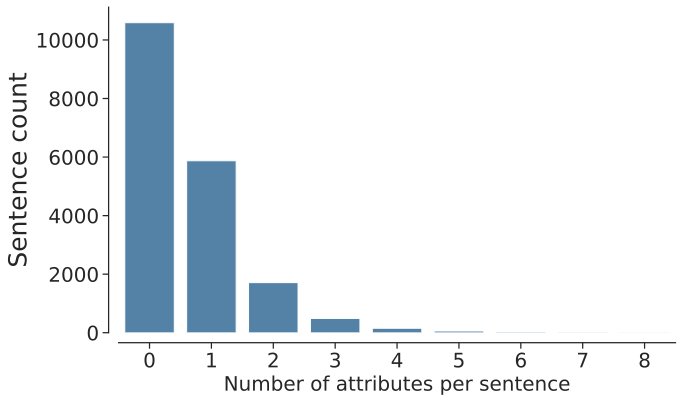

In [14]:

## get the frequency of the previously created column counting attributes per sentence
attribute_distribution = pd.DataFrame(training_data['sum_true'].value_counts())
attribute_distribution['nr_attributes'] = attribute_distribution.index
attribute_distribution.columns = ['nr_sentences','nr_attributes']


fig, ax = plt.subplots(figsize=(10,6))   
ax =  sns.barplot(x="nr_attributes", y="nr_sentences", data=attribute_distribution,color = 'steelblue')
sns.despine(offset=10, trim=False)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.set_xlabel("Number of attributes per sentence",fontsize=20)
ax.set_ylabel("Sentence count",fontsize=25)
ax.tick_params(labelsize=20)
plt.savefig(save_path_figures + "/training_data_sentence_att_{}.pdf".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.savefig(save_path_figures + "/training_data_sentence_att_{}.png".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.show()

##### More intuitive is to plot as a waffle:

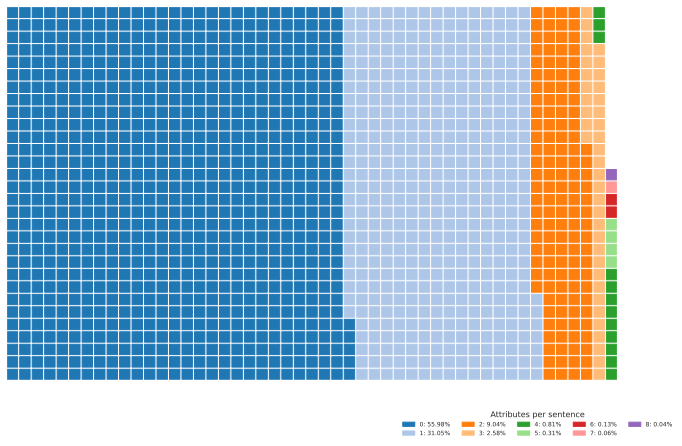

In [15]:
attribute_distribution['proportion'] = round(attribute_distribution['nr_sentences']/attribute_distribution['nr_sentences'].sum()*100,2)
palette = sns.color_palette("tab20")[0:9]
attribute_distribution['legend'] = attribute_distribution['nr_attributes'].astype(str) +': ' + attribute_distribution['proportion'].astype(str) + '%'
test = pd.Series(attribute_distribution.nr_sentences.values,index=attribute_distribution.nr_attributes).to_dict()

fig = plt.figure(
    FigureClass=Waffle, 
    rows=30, 
    values=list(attribute_distribution.nr_sentences/13),
    colors = palette,
    figsize=(10, 8),
        legend={'labels':list(attribute_distribution.legend),
            'loc': 'upper right', 'bbox_to_anchor': (1.1, -0.07), 
            'ncol': 5, 
            'framealpha': 0,
            'title':'Attributes per sentence',
            'title_fontsize':8,
            'fontsize': 6
               }    
)
plt.savefig(save_path_figures + "/training_data_waffle_sentence_att_{}.pdf".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.savefig(save_path_figures + "/training_data_waffle_sentence_att_{}.png".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.show()


### What is the relationship between sentence length and number of attributes?
We expect that longer sentences have more attributes

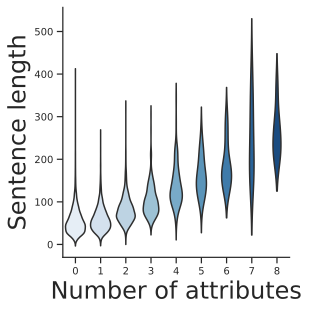

In [16]:
g = sns.catplot(x='sum_true', y='sentence_length', data=training_data,kind="violin",inner=None, palette='Blues')
plt.xlabel("Number of attributes")
plt.ylabel("Sentence length")
plt.tick_params(labelsize=10)
plt.savefig(save_path_figures + "/training_data_violin_sentence_length_attributes_{}.png".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.savefig(save_path_figures + "/training_data_violin_sentence_length_attributes_{}.pdf".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.show()

### Training set: sentence distribution
We expect to find differences in how many sentences each donor has

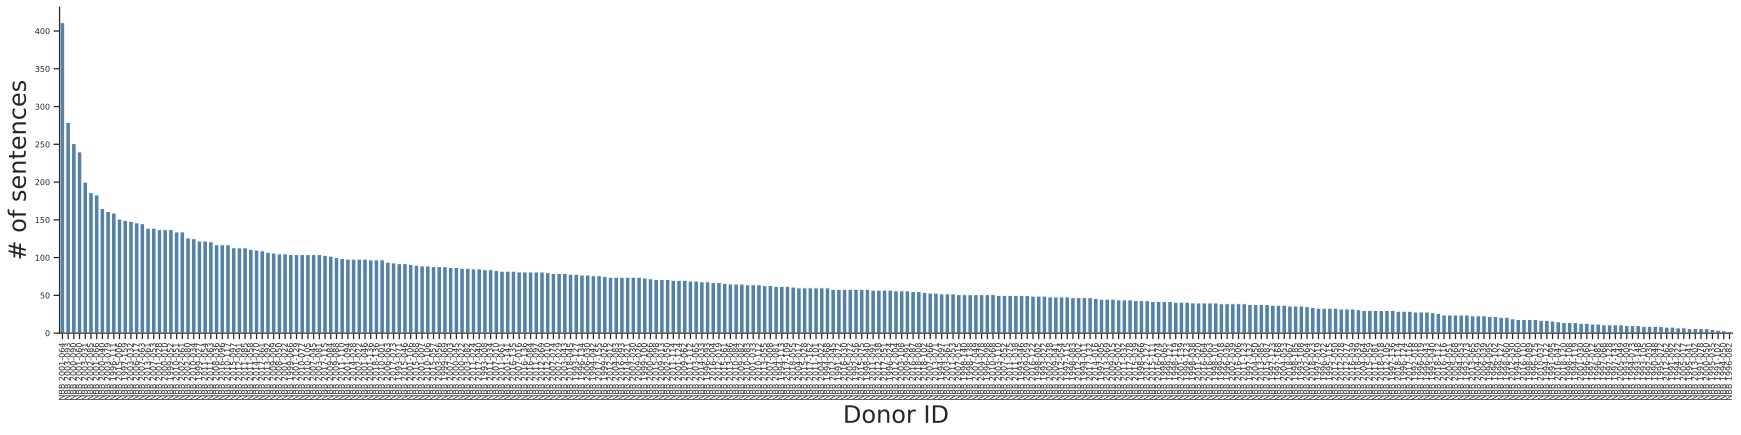

In [17]:
%config InlineBackend.figure_format = 'svg'
sns.set(rc={'figure.figsize':(30,6)},font_scale = 2) #
sns.set_palette("pastel")
sns.set_style("ticks")

## NBB nr frequency df
sentences_per_donor = pd.DataFrame(training_data['NBB_nr'].value_counts())
sentences_per_donor['x'] = sentences_per_donor.index
sentences_per_donor.columns = ['nr_sentences','NBB_nr']

## plot
ax = sns.barplot(x="NBB_nr", y="nr_sentences", data=sentences_per_donor, color='steelblue')
plt.xlabel("Donor ID")
plt.ylabel("# of sentences")

plt.tick_params(labelsize=8)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
plt.xticks(rotation=90)
plt.savefig(save_path_figures + "/training_data_sentences_per_donor_{}.png".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.savefig(save_path_figures + "/training_data_sentences_per_donor_{}.pdf".format(date.today()),
            bbox_inches="tight",dpi=600)
plt.show()